In [1]:
import warnings
from importlib import reload
from functools import partial, lru_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange
from joblib import delayed
from modAL import batch
from art.metrics import empirical_robustness
from art.attacks.evasion import *
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from art.metrics import empirical_robustness
from thundersvm import SVC as ThunderSVC
from art.estimators.classification.scikitlearn import ScikitlearnSVC

from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
from libactive import MyActiveLearner, active_split
from libadversarial import adversarial, uncertainty, random_batch, uncertainty_synthesis, random_synthesis
from libutil import ProgressParallel
from libdatasets import *
import librun
from librun import run

Using sklearn


In [2]:
def stopping_func(learner, metrics):
    return learner.X_training.shape[0] > 400

## Does Uncertainty-optimization perform well with a RBF Kernel?

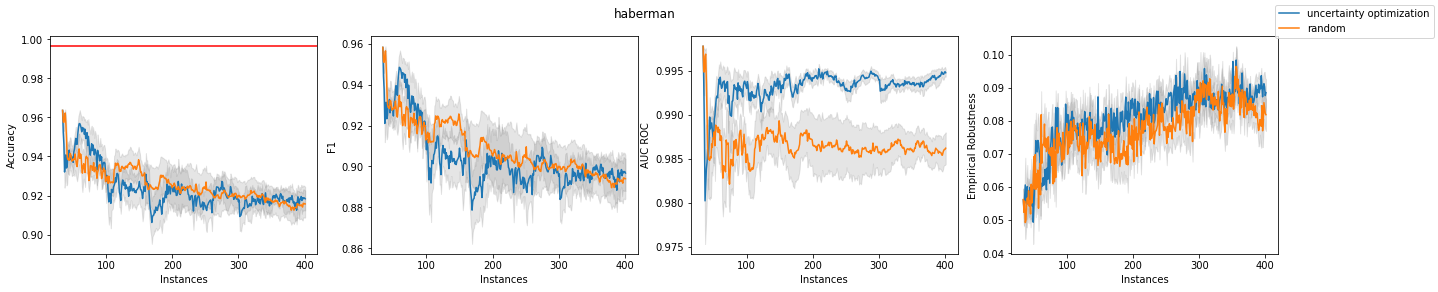

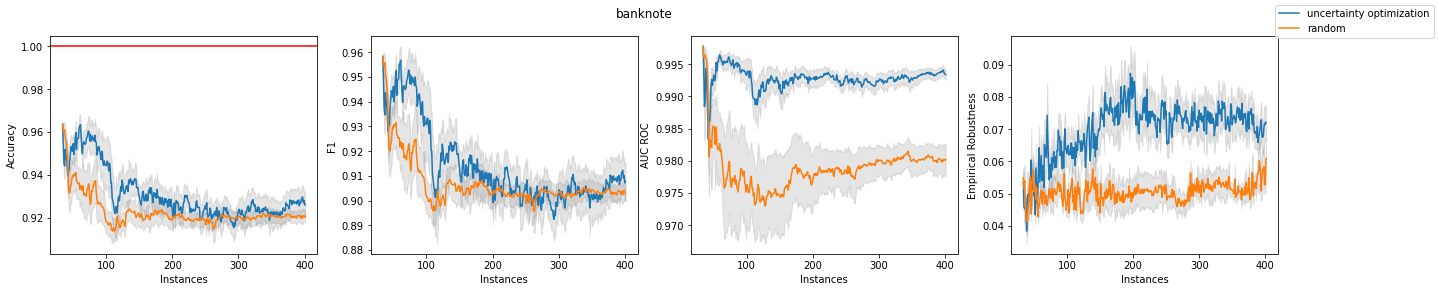

In [4]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

datasets = {
    "haberman": lambda: lru_cache(haberman)(),
    "banknote": lambda: lru_cache(banknote)(),    
    #"car": lambda: lru_cache(car)(),
}

for dataset_name, dataset in tqdm(datasets.items(), desc="Dataset", leave=False):
    X, y = dataset()
    if dataset_name == "car":
        y = LabelEncoder().fit_transform(y)
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.025)
    
    solver_params = {
        'eta': 0.3297953991427548,
        'eta_min': None,
        'eta_max': None,
        'max_iter': 100,
        'eps': 0.7261519961245426
    }
    
    query_methods = {
        "uncertainty optimization": partial(uncertainty_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
        "random": partial(random_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
    }
    
    oracle = svm.SVC(kernel='rbf')
    oracle.fit(X, y)
    
    fig, axes = plt.subplots(1, 4, figsize=(22,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        try:
            metrics = pd.read_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_rbf.csv", index_col=0)
            stderr = pd.read_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_rbf_stderr.csv", index_col=0)
        except FileNotFoundError:
            metrics = ProgressParallel(n_jobs=3, total=10, desc=f"Run", leave=False)(
                delayed(
                    lambda X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, method: MyActiveLearner(metrics=[accuracy_score, f1_score, roc_auc_score, empirical_robustness]).active_learn_query_synthesis(X_biased, y_biased, lambda x: oracle.predict(x), X_test, y_test, method, stopping_func, track_flips=True, model="svm-rbf")
                )(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method)
                for _ in range(10)
            )
            metrics, stderr = metrics[0].average(metrics[1:])
            metrics.to_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_rbf.csv")
            stderr.to_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_rbf_stderr.csv")
        
        for i, ax in enumerate(axes.flatten()):
            if len(metrics['x']) > 100:
                ax.plot(metrics['x'], metrics.iloc[:,1+i], '-', label=f"{name}" if i == 0 else "")
                ax.fill_between(metrics['x'], metrics.iloc[:,1+i]-stderr.iloc[:,1+i], metrics.iloc[:,1+i]+stderr.iloc[:,1+i], color='grey', alpha=0.2)
            else:
                ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC", "Empirical Robustness"][i]); plt.suptitle(f"{dataset_name}")
    
    axes[0].axhline(accuracy_score(y, oracle.predict(X)), color="red")
    fig.legend()

Not what I expected...

## Does Uncertainty-optimization perform well with a Polynomial Kernel?

First model might be overfitting and the second one not? Not sure if this is a problem for my evaluation strategy.

**Oracle trained on all.**

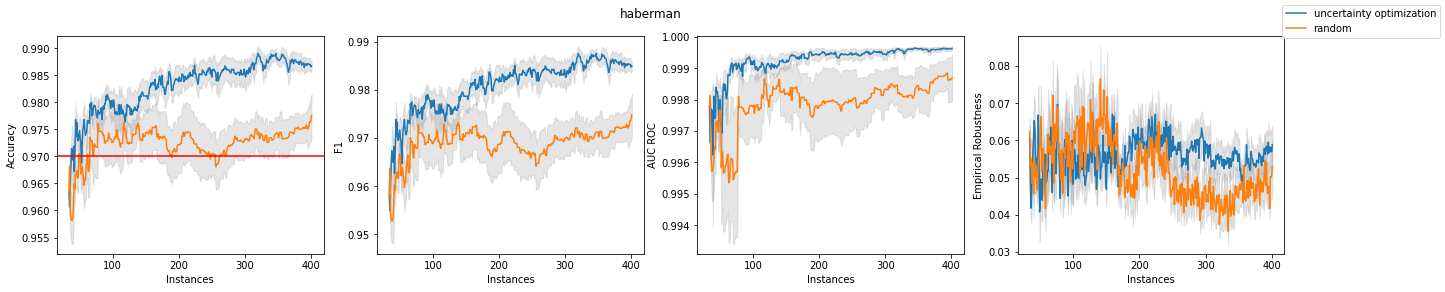

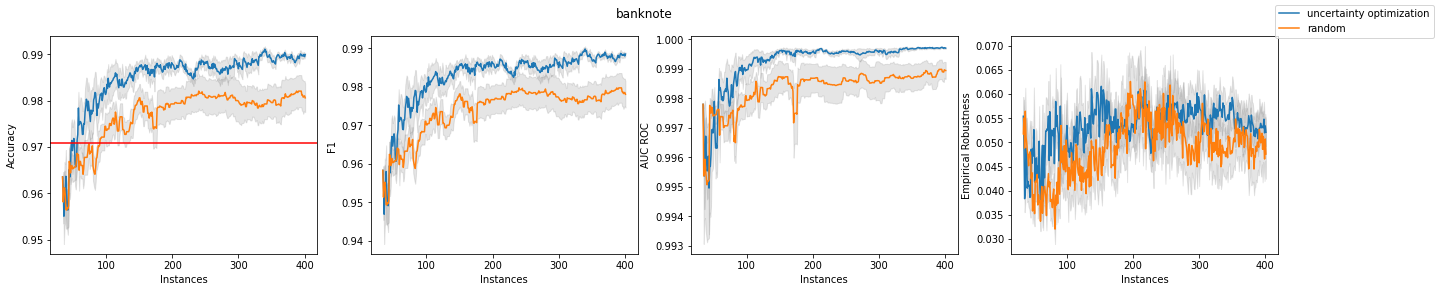

In [6]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

datasets = {
    "haberman": lambda: lru_cache(haberman)(),
    "banknote": lambda: lru_cache(banknote)(),    
    #"car": lambda: lru_cache(car)(),
}

for dataset_name, dataset in tqdm(datasets.items(), desc="Dataset", leave=False):
    X, y = dataset()
    if dataset_name == "car":
        y = LabelEncoder().fit_transform(y)
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.025)
    
    solver_params = {
        'eta': 0.3297953991427548,
        'eta_min': None,
        'eta_max': None,
        'max_iter': 100,
        'eps': 0.7261519961245426
    }
    
    query_methods = {
        "uncertainty optimization": partial(uncertainty_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
        "random": partial(random_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
    }
    
    oracle = svm.SVC(kernel='poly')
    oracle.fit(X, y)
    
    fig, axes = plt.subplots(1, 4, figsize=(22,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        try:
            metrics = pd.read_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_poly.csv", index_col=0)
            stderr = pd.read_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_poly_stderr.csv", index_col=0)
        except FileNotFoundError:
            metrics = ProgressParallel(n_jobs=3, total=10, desc=f"Run", leave=False)(
                delayed(
                    lambda X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, method: MyActiveLearner(metrics=[accuracy_score, f1_score, roc_auc_score, empirical_robustness]).active_learn_query_synthesis(X_biased, y_biased, lambda x: oracle.predict(x), X_test, y_test, method, stopping_func, track_flips=True, model="svm-poly")
                )(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method)
                for _ in range(10)
            )
            metrics, stderr = metrics[0].average(metrics[1:])
            metrics.to_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_rbf.csv")
            stderr.to_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_rbf_stderr.csv")
        
        for i, ax in enumerate(axes.flatten()):
            if len(metrics['x']) > 100:
                ax.plot(metrics['x'], metrics.iloc[:,1+i], '-', label=f"{name}" if i == 0 else "")
                ax.fill_between(metrics['x'], metrics.iloc[:,1+i]-stderr.iloc[:,1+i], metrics.iloc[:,1+i]+stderr.iloc[:,1+i], color='grey', alpha=0.2)
            else:
                ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC", "Empirical Robustness"][i]); plt.suptitle(f"{dataset_name}")
    
    axes[0].axhline(accuracy_score(y, oracle.predict(X)), color="red")
    fig.legend()

**Oracle trained on all sans validation set.**

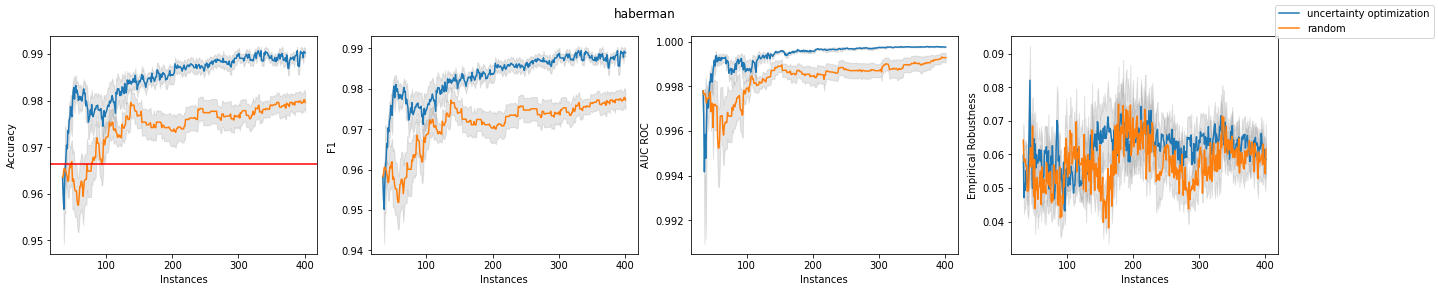

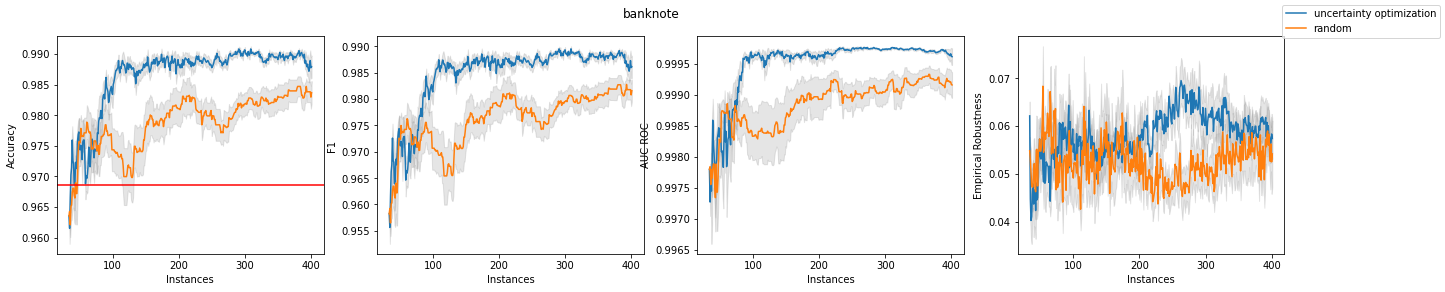

In [3]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

datasets = {
    "haberman": lambda: lru_cache(haberman)(),
    "banknote": lambda: lru_cache(banknote)(),    
    #"car": lambda: lru_cache(car)(),
}

for dataset_name, dataset in tqdm(datasets.items(), desc="Dataset", leave=False):
    X, y = dataset()
    if dataset_name == "car":
        y = LabelEncoder().fit_transform(y)
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.025)
    
    solver_params = {
        'eta': 0.3297953991427548,
        'eta_min': None,
        'eta_max': None,
        'max_iter': 100,
        'eps': 0.7261519961245426
    }
    
    query_methods = {
        "uncertainty optimization": partial(uncertainty_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
        "random": partial(random_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
    }
    
    oracle = svm.SVC(kernel='poly')
    oracle.fit(np.append(X_labelled, X_unlabelled, axis=0), np.append(y_labelled, y_oracle, axis=0))
    
    fig, axes = plt.subplots(1, 4, figsize=(22,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        try:
            metrics = pd.read_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_poly.csv", index_col=0)
            stderr = pd.read_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_poly_stderr.csv", index_col=0)
        except FileNotFoundError:
            metrics = ProgressParallel(n_jobs=3, total=10, desc=f"Run", leave=False)(
                delayed(
                    lambda X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, method: MyActiveLearner(metrics=[accuracy_score, f1_score, roc_auc_score, empirical_robustness]).active_learn_query_synthesis(X_biased, y_biased, lambda x: oracle.predict(x), X_test, y_test, method, stopping_func, track_flips=True, model="svm-poly")
                )(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method)
                for _ in range(10)
            )
            metrics, stderr = metrics[0].average(metrics[1:])
            metrics.to_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_rbf.csv")
            stderr.to_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_rbf_stderr.csv")
        
        for i, ax in enumerate(axes.flatten()):
            if len(metrics['x']) > 100:
                ax.plot(metrics['x'], metrics.iloc[:,1+i], '-', label=f"{name}" if i == 0 else "")
                ax.fill_between(metrics['x'], metrics.iloc[:,1+i]-stderr.iloc[:,1+i], metrics.iloc[:,1+i]+stderr.iloc[:,1+i], color='grey', alpha=0.2)
            else:
                ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC", "Empirical Robustness"][i]); plt.suptitle(f"{dataset_name}")
    
    axes[0].axhline(accuracy_score(y, oracle.predict(X)), color="red")
    fig.legend()